In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.python.framework import ops

In [3]:
#Read the csv file 
df = pd.read_csv('10-09.csv')

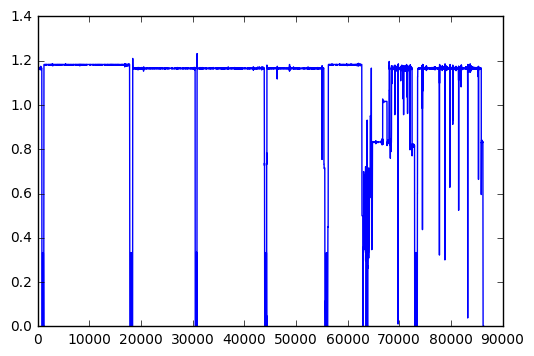

In [4]:
#PLot the shape of transition of a Colmm_name
plt.plot(df['Tag1'])
plt.show()

In [5]:
#Convert to numpy array 
raw_data = pd.DataFrame.as_matrix(df)

In [6]:
#Removing the time Colmn and labels
data = raw_data[:,1:-1]
labels = raw_data[:,-1]

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

/home/peyush/DeepLearning/tfEnv/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [10]:
#Getting the dataset into batches of sequences (batch_size * seq_len * lengthOfSequence)
seq_len = 10
data_seq = []
for i in range(len(data) - seq_len):
    data_seq.append(data[i:i+seq_len, :])

data_seq = np.array(data_seq)
print data_seq.shape

labels_seq = labels[seq_len:len(labels)]
print labels_seq.shape

(86390, 10, 9)
(86390,)


In [11]:
#Changing Name of Variables 
data = data_seq
labels = labels_seq

In [12]:
#Taking in training examples and give out a batch
def sample_batch(X_train,y_train,batch_size,num_steps = seq_len):
    """ Function to sample a batch for training"""
    N,seq_len, size = X_train.shape
    ind_N = np.random.choice(N,batch_size,replace=False)
    #ind_start = np.random.choice(data_len-num_steps,1)
    X_batch = X_train[ind_N]
    y_batch = y_train[ind_N]
    return X_batch,y_batch

In [13]:
#Test the accuracies in the batch of Test examples
def check_test(X_test,y_test,batch_size,num_steps= seq_len):
    """ Function to check the test_accuracy on the entire test set"""
    N = X_test.shape[0]
    num_batch = np.floor(N/batch_size)
    test_acc = np.zeros(num_batch)
    for i in range(int(num_batch)):
        X_batch, y_batch = sample_batch(X_test,y_test,batch_size,num_steps)
        test_acc[i] = sess.run(accuracy,feed_dict = {input_data: X_batch, targets: y_batch,keep_prob:1})
    return np.mean(test_acc)



In [14]:
#Get the validation dataset from the data
val_size = int(len(data) * 0.2)
X_val, y_val  = data[len(data) - val_size:len(data), :], labels[len(labels) - val_size:len(labels)]
data = data[0:len(data)-val_size,:]
labels = labels[0:len(labels) - val_size]

In [15]:
X_val.shape

(17278, 10, 9)

In [16]:
#Getting TEst set from reamining examples
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
X_train, X_test = data[0:train_size,:,:], data[train_size:len(data),:,:]
y_train, y_test = labels[0:train_size], labels[train_size:len(labels)]
print(X_train.shape, (X_test).shape)

((46305, 10, 9), (22807, 10, 9))


In [17]:
#Convert labels to oone hot encoding
num_classes = len(np.unique(labels))
def dense_to_one_hot(labels_dense, num_classes=num_classes):
    """Convert class labels from scalars to one-hot vectors."""
    labels_dense = np.array(labels_dense, dtype=int)
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [18]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=object)

In [19]:
"""Hyperparamaters to tune on"""
max_grad_norm = 5           #Clipping of the gradient before update
num_layers = 1              #Number of stacked LSTM layers
num_steps = 7               #Number of steps to backprop over at every batch
hidden_size = 13            #Number of entries of the cell state of the LSTM
max_iterations = 2000       #Maximum iterations to train
batch_size = 40             #Batch size
dropout = 0.8               #Keep probability of the dropout wrapper

In [20]:
#Getting number of examples in the all the sets 
N = X_train.shape[0]
Ntest = X_test.shape[0]
print N, Ntest

46305 22807


In [21]:
num_steps = seq_len
step_len = X_train.shape[2]

# Collect the costs in a numpy fashion
epochs = np.floor(batch_size*max_iterations / N)
print('Train with approximately %d epochs' %(epochs))
perf_collect = np.zeros((3,int(np.floor(max_iterations /100))))


"""Place holders"""
input_data = tf.placeholder(tf.float32, [None, num_steps, step_len], name = 'input_data')
targets = tf.placeholder(tf.int64, [None], name='Targets')
keep_prob = tf.placeholder("float", name = 'Drop_out_keep_prob')

#Settin up the model
with tf.name_scope("LSTM_setup") as scope:
    cell = tf.nn.rnn_cell.LSTMCell(hidden_size)
    cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)
    #inputs = tf.expand_dims(input_data, 2)
    #tf.Print(inputs, [inputs])

Train with approximately 1 epochs


In [22]:
#Define the recurrent nature of the LSTM
#Feeding the sequence of vectors one step at a time for the batch
with tf.name_scope("LSTM") as scope:
    outputs = []
    state = initial_state
    with tf.variable_scope("LSTM_state"):
        for time_step in range(num_steps):
            if time_step > 0: tf.get_variable_scope().reuse_variables() #Re-use variables only after first time-step
            (cell_output, state) = cell(input_data[:, time_step, :], state)
            outputs.append(cell_output)       #Now cell_output is size [batch_size x hidden_size]
    output = tf.reduce_mean(tf.pack(outputs),0)

In [23]:
#Generate a classification from the last cell_output
#We only output to Softmax at last time step
with tf.name_scope("Softmax") as scope:
    with tf.variable_scope("Softmax_params"):
        softmax_w = tf.get_variable("softmax_w", [hidden_size, num_classes])
        softmax_b = tf.get_variable("softmax_b", [num_classes])
    logits = tf.nn.xw_plus_b(output, softmax_w, softmax_b)
    #Use sparse Softmax because we have mutually exclusive classes
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits,targets,name = 'Sparse_softmax')
    cost = tf.reduce_sum(loss) / batch_size
with tf.name_scope("Evaluating_accuracy") as scope:
    correct_prediction = tf.equal(tf.argmax(logits,1),targets)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [24]:
"""Optimizer"""
with tf.name_scope("Optimizer") as scope:
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars),max_grad_norm)   #We clip the gradients to prevent explosion
    optimizer = tf.train.AdamOptimizer(5e-3)
    gradients = zip(grads, tvars)
    train_op = optimizer.apply_gradients(gradients)

In [25]:

"""Session time"""
sess = tf.Session() #do not forget to close the session
sess.run(tf.initialize_all_variables())

In [26]:
X_train.shape

(46305, 10, 9)

In [27]:
step = 0
cost_train_ma = -np.log(1/float(num_classes)+1e-9)  #Moving average training cost
for i in range(max_iterations):
    # Calculate some sizes
    N = X_train.shape[0]
    #Sample batch for training
    X_batch, y_batch = sample_batch(X_train,y_train,batch_size,num_steps)

    #Next line does the actual training
    cost_train, _ = sess.run([cost, train_op],
                             feed_dict = {input_data: X_batch,targets: y_batch,keep_prob:dropout})
    cost_train_ma = cost_train_ma*0.99 + cost_train*0.01
    if i%100 == 0:
        #Evaluate training performance
        perf_collect[0,step] = cost_train

        #Evaluate validation performance
        X_batch, y_batch = sample_batch(X_val,y_val,batch_size,num_steps)
        result = sess.run([cost ,accuracy],
                          feed_dict = {input_data: X_batch, targets: y_batch, keep_prob:1})
        cost_val = result[0]
        perf_collect[1,step] = cost_val
        acc_val = result[1]
        perf_collect[2,step] = acc_val
        print('At %5.0f out of %5.0f: Cost is TRAIN%.3f(%.3f) VAL%.3f and val acc is %.3f'
              %(i,max_iterations,cost_train,cost_train_ma,cost_val,acc_val))

        step +=1
acc_test = check_test(X_test,y_test,batch_size,num_steps)

At     0 out of  2000: Cost is TRAIN2.266(2.198) VAL2.377 and val acc is 0.000
At   100 out of  2000: Cost is TRAIN1.159(1.492) VAL1.203 and val acc is 0.575
At   200 out of  2000: Cost is TRAIN0.945(1.134) VAL0.908 and val acc is 0.725
At   300 out of  2000: Cost is TRAIN0.810(0.992) VAL1.202 and val acc is 0.600
At   400 out of  2000: Cost is TRAIN0.845(0.941) VAL0.840 and val acc is 0.750
At   500 out of  2000: Cost is TRAIN0.942(0.925) VAL1.030 and val acc is 0.700
At   600 out of  2000: Cost is TRAIN1.031(0.919) VAL0.942 and val acc is 0.700
At   700 out of  2000: Cost is TRAIN0.899(0.905) VAL0.953 and val acc is 0.750
At   800 out of  2000: Cost is TRAIN0.877(0.900) VAL0.970 and val acc is 0.600
At   900 out of  2000: Cost is TRAIN1.239(0.881) VAL0.929 and val acc is 0.700
At  1000 out of  2000: Cost is TRAIN0.756(0.884) VAL0.932 and val acc is 0.725
At  1100 out of  2000: Cost is TRAIN0.798(0.895) VAL0.855 and val acc is 0.700
At  1200 out of  2000: Cost is TRAIN1.007(0.879) VAL

/home/peyush/DeepLearning/tfEnv/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


The accuracy on the test data is 0.635


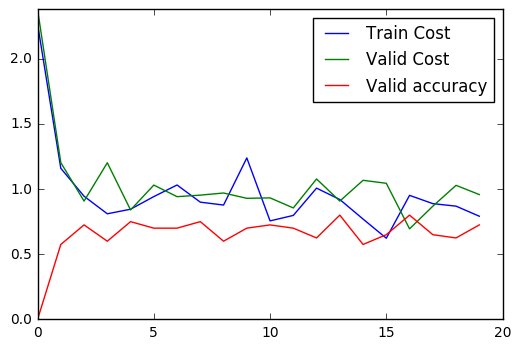

In [28]:
"""Additional plots"""
print('The accuracy on the test data is %.3f' %(acc_test))
plt.plot(perf_collect[0],label='Train Cost')
plt.plot(perf_collect[1],label = 'Valid Cost')
plt.plot(perf_collect[2],label = 'Valid accuracy')
plt.axis([0, step, 0, np.max(perf_collect)])
plt.legend()
plt.show()